# Семинар 7 - Линейная и гауссовы регрессии

##### Краткий синопсис:
1. Линейная регрессия
2. AIC, BIC, CV и bias-variance decomposition вместе с...
3. ...RVM(advanced, yet fun, topic)
4. Gaussian Processes in a nutshell;
5. `GPy`;
6. GP with `Deep Kernel Learing`;

http://scikit-learn.org/stable/modules/linear_model.html

In [1]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
np.random.seed(42)
warnings.filterwarnings("ignore")

# 1. Линейная регрессия.

## Про сигналы, фильтры и стабильность$^{\mathrm{TM}}$

### Построим сигнал, который представляет собой модулированную синусоиду

In [2]:
a1 = 10.
a2 = 1.
w1 = 1.
w2 = 12.
N = 256

In [3]:
x = np.linspace(-4, 4, N)
f = a1 * np.sin(w1 * x) + a2 * np.sin(w2 * x)

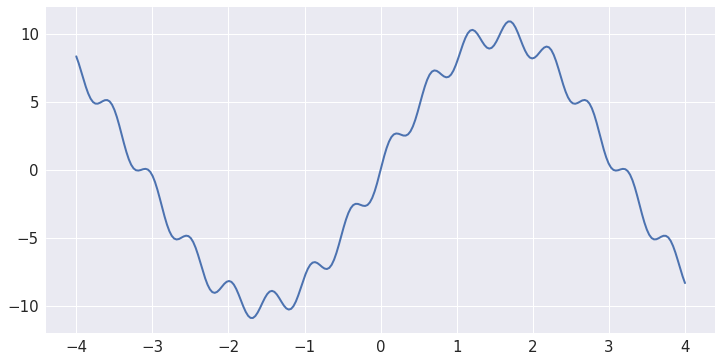

In [4]:
plt.figure(figsize=(12,6))
plt.plot(x, f, linewidth=2)

Сгенерируем оператор, который определяется матрицей $A$ ленточного вида.

Такой оператор соответствует как если бы сигнал обработали moving average, т.е. производит усреднение по некоторому скользящему окну.

In [5]:
A = np.eye(N)
for k in range(1, 15):
    A += np.diag(np.ones(N), k=k)[:N, :N]
    A += np.diag(np.ones(N), k=-k)[:N, :N]

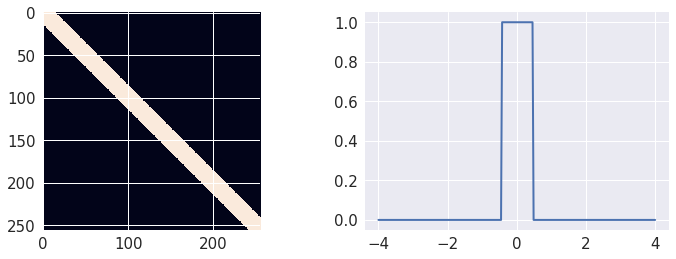

In [6]:
fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axs[0].imshow(A)
axs[1].plot(x, A[N // 2,:], linewidth=2)

Сгенерируем выборку $xi$ умножив нашу диагональную матрицу $A$ на наш сигнал $f$.

Т.е. эффективно сгладив сигнал moving average.

In [7]:
sigma = 2
noise = sigma * np.random.randn(N)
xi = np.dot(A, f) + noise

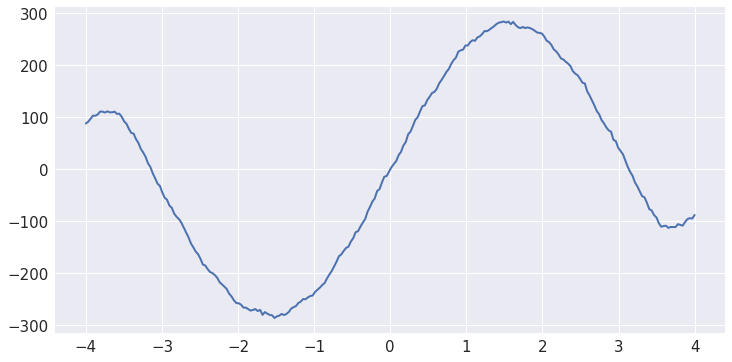

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(x, xi, linewidth=2)

### 1.1 LEAST SQUARES ESTIMATE

Первым делом попробуем восстановить сигнал с помощью LSE, т.е. с помощью метода наименьших квадратов.

$$Af = \xi$$

Матрица псевдорешения(псевдообратная матрица):

$$A^+ = (A^T A)^{-1} A^T$$

Тогда решение можно представить следующим образом:

$$f = A^+ \xi$$

In [9]:
R = np.dot(
        np.linalg.inv(np.dot(A.T, A)),
        A.T
    )
Rxi = np.dot(R, xi)

Text(0.5, 1.0, 'Восстановленный сигнала с помощью LSE')

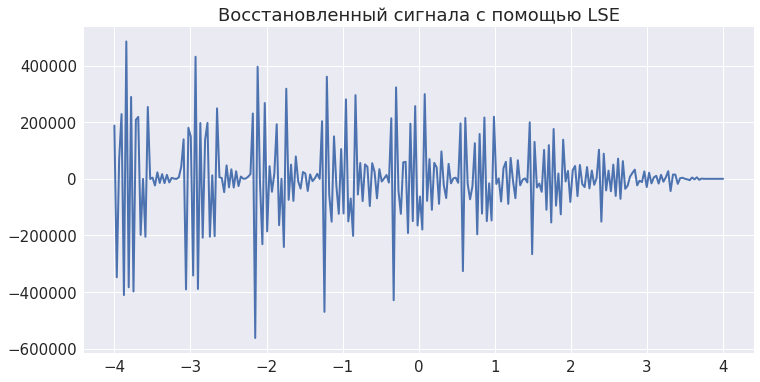

In [10]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi, linewidth=2)
plt.title('Восстановленный сигнала с помощью LSE')

## Что произошло?

Наш вариант реализации псевдообратной является неканоничным и страдает из-за плохих собственных значений.
Поэтому лучше использовать специализированные пакеты, которые более эффективно вычисляют псевдообратные матрицы.

https://en.wikipedia.org/wiki/Generalized_inverse

In [11]:
np.linalg.pinv?

In [12]:
R_pinv = np.linalg.pinv(A)
R_pinv_xi = np.dot(R_pinv, xi)

Text(0.5, 1.0, 'Восстановленный сигнал с помощью np.linalg.pinv')

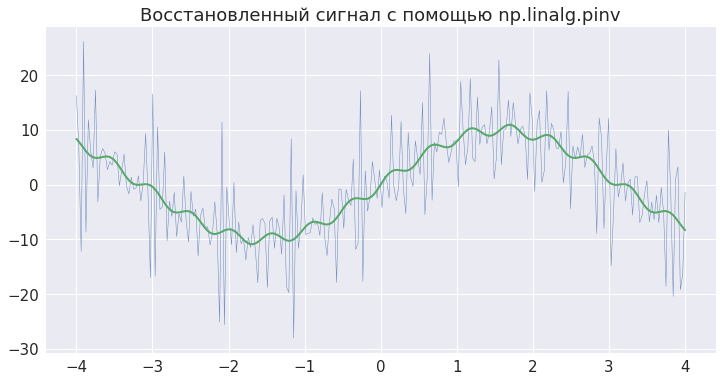

In [13]:
plt.figure(figsize=(12,6))
plt.plot(x, R_pinv_xi, linewidth=0.5, alpha=0.8)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал с помощью np.linalg.pinv')

### NOT QUITE THERE YET. REGULARIZE!

In [14]:
c = 1e-3
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    ) 
Rxi_reg = np.dot(R_reg, xi)

Text(0.5, 1.0, 'Восстановленный сигнал при включении регуляризации')

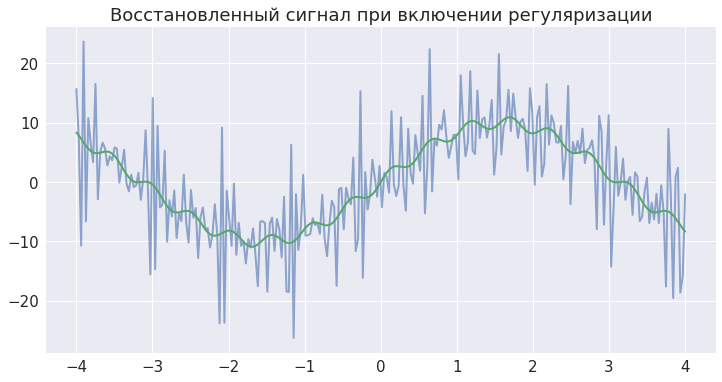

In [15]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

#### Как выбирать коэффициент регуляризации?

In [16]:
reg_coeffs = np.linspace(0.1, 20, 80)
reg_loss = []
for c in reg_coeffs:
    R_reg = np.dot(
            np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
            A.T
        )
    Rxi_reg = np.dot(R_reg, xi)
    loss = np.sum((f - Rxi_reg)**2)
    reg_loss.append(loss)

Text(0.5, 1.0, 'MSE в зависимости от коэффициента регуляризации')

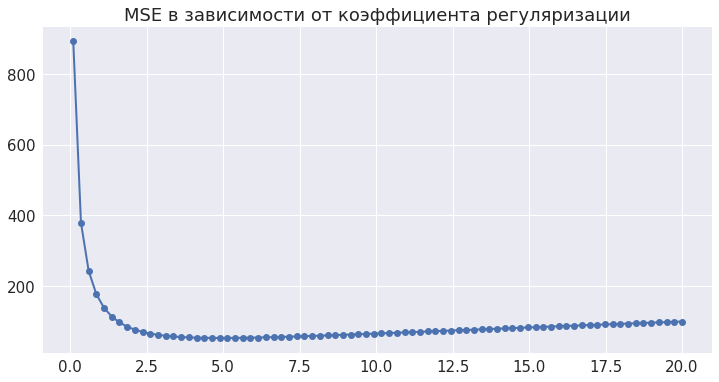

In [17]:
plt.figure(figsize=(12,6))
plt.plot(reg_coeffs, reg_loss, 'o-', linewidth=2)
plt.title('MSE в зависимости от коэффициента регуляризации')

In [18]:
reg_coeffs[np.argmin(reg_loss)]

4.886075949367087

In [19]:
c = 4.886075949367087
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    )
Rxi_reg = np.dot(R_reg, xi)

Text(0.5, 1.0, 'Восстановленный сигнал при включении регуляризации')

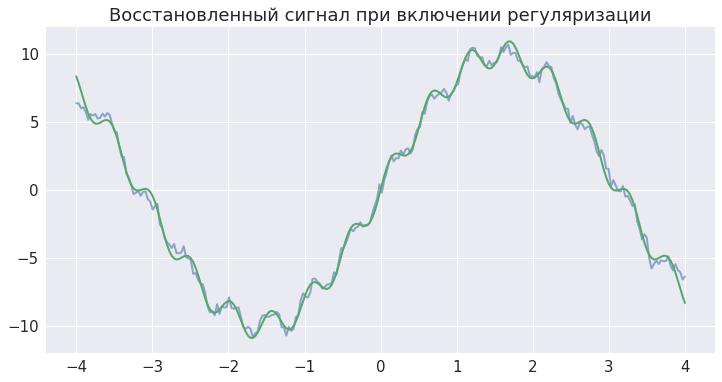

In [20]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

###  SVD

$$A_{n \times m } = U_{m \times m } \Sigma_{m \times n } V_{n \times n }$$

In [21]:
U, S, V = np.linalg.svd(A)

Text(0.5, 1.0, 'Собственные числа оператора A')

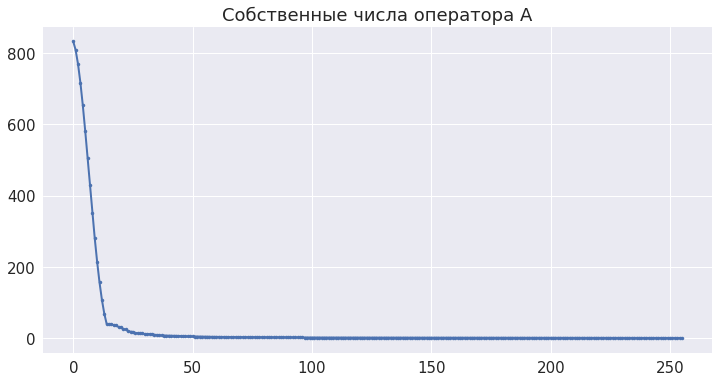

In [22]:
plt.figure(figsize=(12,6))
plt.plot(S**2, '.-', linewidth=2)
plt.title('Собственные числа оператора A')

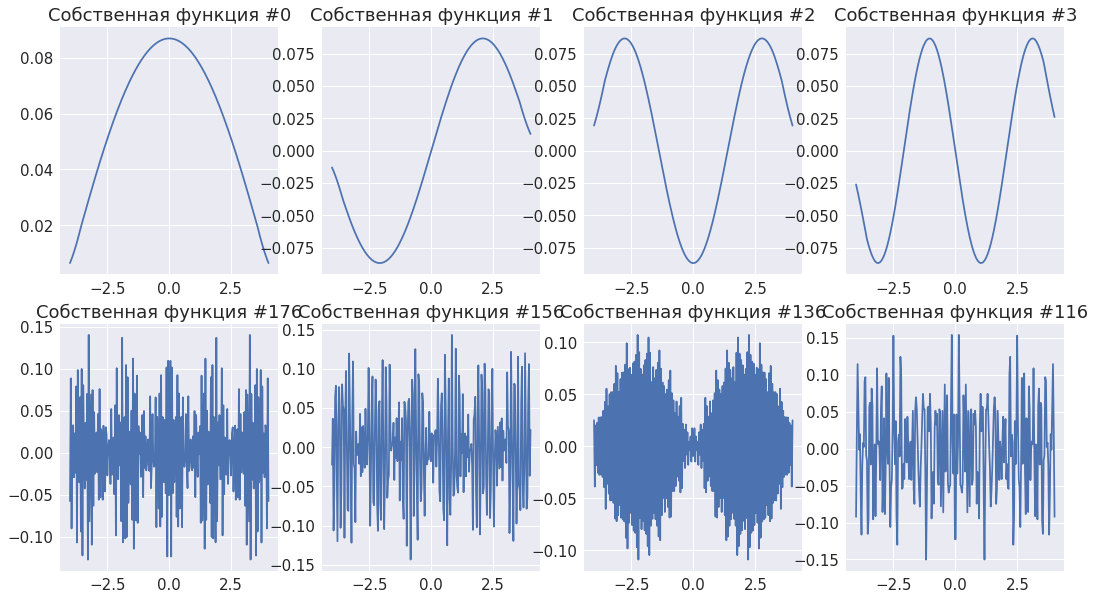

In [23]:
fig, axs = plt.subplots(figsize=(18, 10), ncols=4, nrows=2)
for i in range(4):
    axs[0, i].plot(x, V[i])
    axs[0, i].set_title('Собственная функция #{}'.format(i))
for i in range(4):
    axs[1, i].plot(x, V[N-(4 + i) * 20])
    axs[1, i].set_title('Собственная функция #{}'.format(N-(4 + i) * 20))

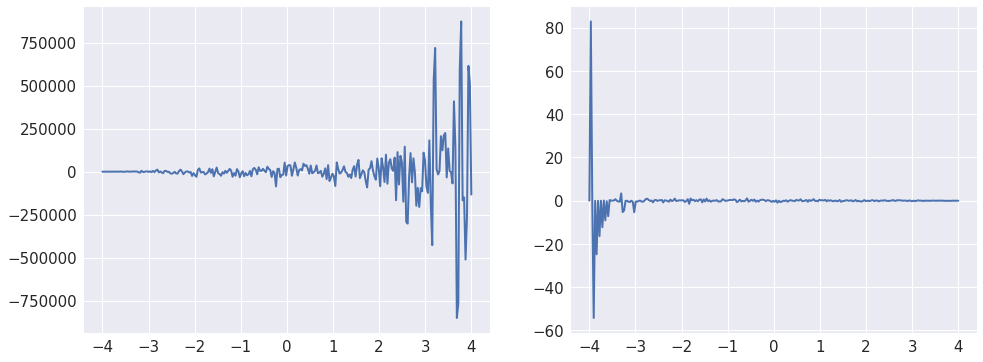

In [24]:
# Отфильтрованный интервал в базисе оператора
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(x, np.dot(V, Rxi), linewidth=2) 
axs[1].plot(x, np.dot(V, Rxi_reg), linewidth=2) 

### Переходим к базису оператора A и сделаем все те же самые трюки что делали раньше

Как перейти к базису оператора A имея матрицы $U$, $V$ и $S$?

In [25]:
f_wave = np.dot(V, f) 
noise_wave = np.dot(V, noise) 

In [26]:
A_wave = np.diag(S)

In [27]:
xi_wave = np.dot(A_wave, f_wave) + noise_wave

Text(0.5, 1.0, 'Отфильтрованный сигнал при переходе ')

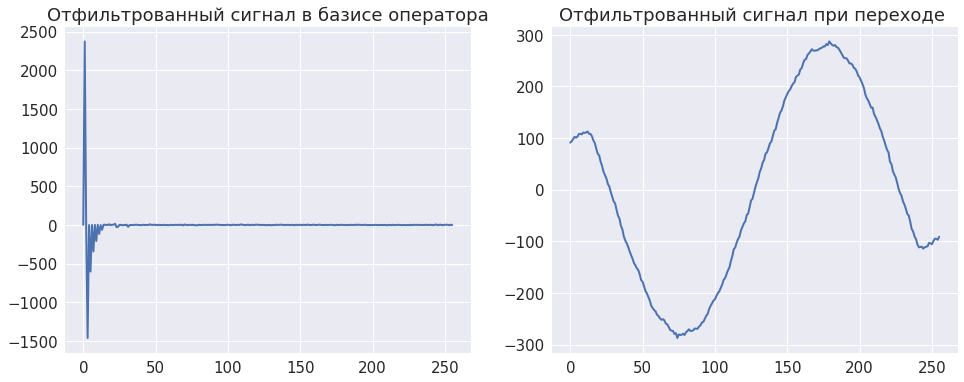

In [28]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)

axs[0].plot(xi_wave, linewidth=2)
axs[0].set_title('Отфильтрованный сигнал в базисе оператора')

# Теперь у нас есть xi_wave -- сигнал в базисе оператора A
# покажем, что это тот самый отфильтрованный сигнал, перейдя обратно в изначальный базис
axs[1].plot(np.dot(V.T, xi_wave), linewidth=2) 
axs[1].set_title('Отфильтрованный сигнал при переходе ')

In [29]:
R_wave = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave)),
        A_wave.T
)
R_wave_xi = np.dot(R_wave, xi_wave)

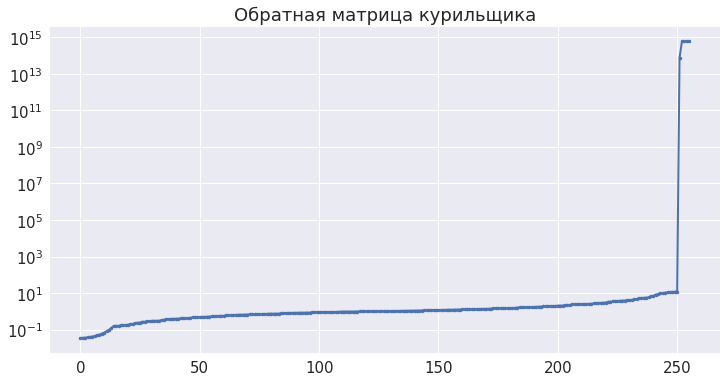

In [30]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_wave), '.-', linewidth=2)
plt.title('Обратная матрица курильщика')
plt.yscale('log')

Text(0.5, 1.0, 'Восстановленный сигнал ')

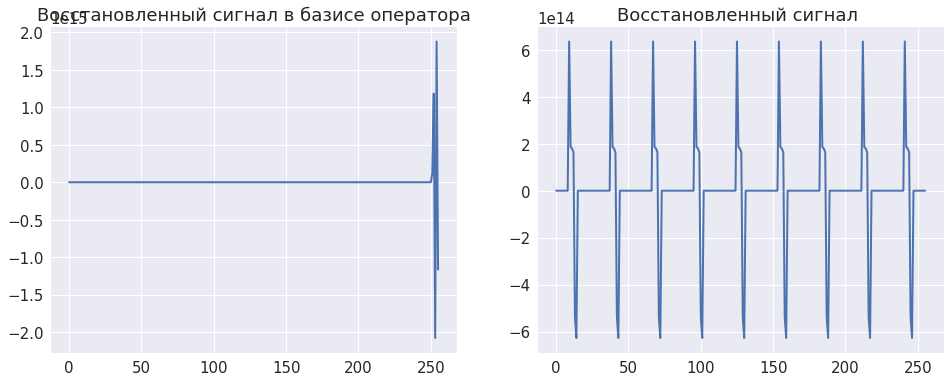

In [31]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(np.dot(V.T, R_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

In [32]:
R_pinv_wave = np.linalg.pinv(A_wave)
R_pinv_wave_xi = np.dot(R_pinv_wave, xi_wave)

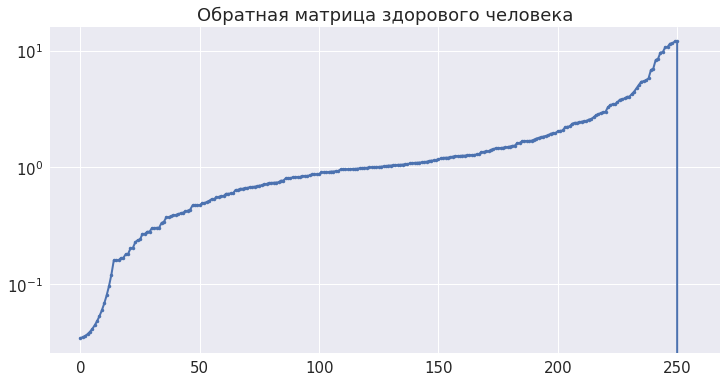

In [33]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_pinv_wave), '.-', linewidth=2)
plt.title('Обратная матрица здорового человека')
plt.yscale('log')

Text(0.5, 1.0, 'Восстановленный сигнал ')

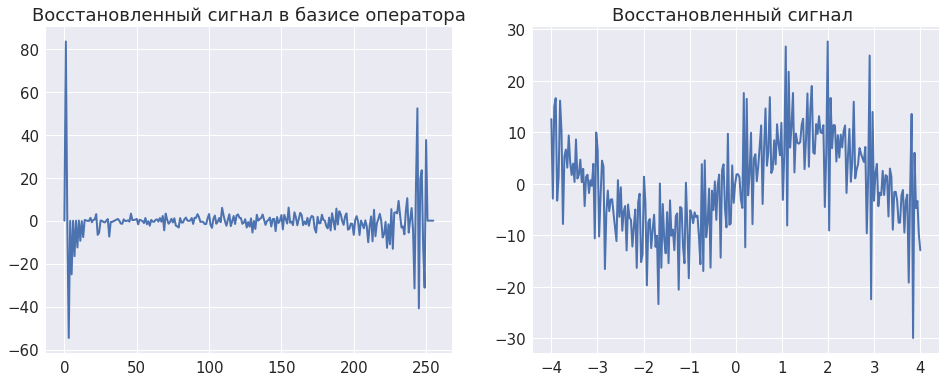

In [34]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_pinv_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(x, np.dot(V.T, R_pinv_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

In [35]:
c = 5.21
R_wave_reg = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave) + c * np.eye(N)),
        A_wave.T
    )
R_wave_xi_reg = np.dot(R_wave_reg, xi_wave)

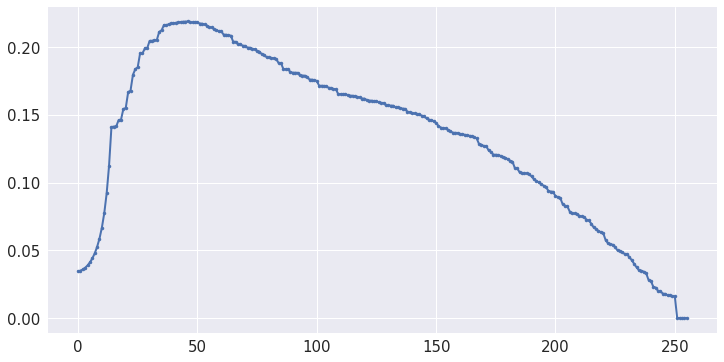

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(np.diag(R_wave_reg), '.-', linewidth=2)

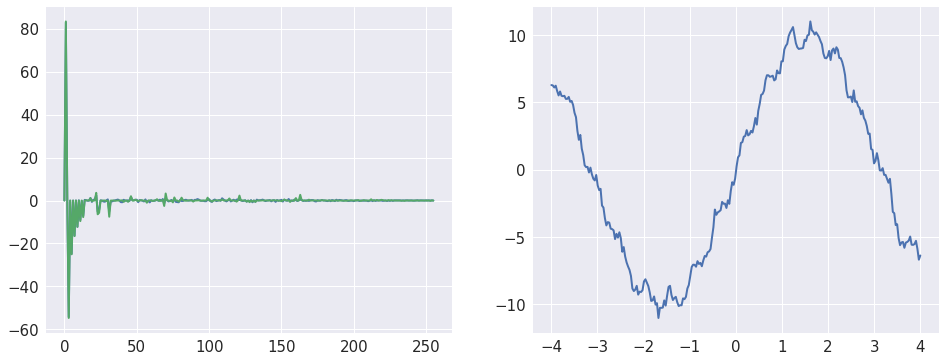

In [37]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi_reg, linewidth=2)
axs[0].plot(f_wave, linewidth=2)
axs[1].plot(x, np.dot(V.T, R_wave_xi_reg), linewidth=2)

# 2. AIC, BIC, CV и bias-variance decomposition


## AIC


One approach to model selection is to use an information-theoretic criterion to identify the most appropriate model. Akaike (1973) found a formal relationship between Kullback-Leibler information (a dominant paradigm in information and coding theory) and likelihood theory. Akaike's Information Criterion (AIC) is an estimator of expected relative K-L information based on the maximized log-likelihood function, corrected for asymptotic bias. 

$$\text{AIC} = −2 \log(L(\theta|data)) + 2K$$

AIC balances the fit of the model (in terms of the likelihood) with the number of parameters required to achieve that fit. We can easily calculate AIC from the residual sums of squares as:

$$\text{AIC} = n \log(\text{RSS}/n) + 2k$$

where $k$ is the number of parameters in the model. Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

To apply AIC to a model selection problem, we choose the model that has the lowest AIC value.

[AIC can be shown to be equivalent to leave-one-out cross-validation](http://www.jstor.org/stable/2984877).

## BIC

In [38]:
import statsmodels.api as sm

In [176]:
N = 2000

x = np.linspace(-20, 40, N)
X = np.vstack([
    x, 
    np.sin(x),
    np.cos(x),
    np.random.randn(N) / 100,
    np.random.randn(N) / 100,
]).T
Y = np.sin(2 * x) + np.random.randn(*x.shape) / 2 + x / 2

In [177]:
from sklearn.cross_validation import train_test_split

In [178]:
X_train, X_test, Y_train, Y_test = X[:len(X) // 2], X[len(X) // 2:], Y[:len(X) // 2], Y[len(X) // 2:]

In [179]:
res = sm.OLS(Y_train, X_train).fit()

In [180]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     6828.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        18:30:29   Log-Likelihood:                -1263.1
No. Observations:                1000   AIC:                             2536.
Df Residuals:                     995   BIC:                             2561.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5009      0.003    183.411      0.000       0.496       0.506
x2             0.0208      0.039      0.534      0.594      -0.056       0.097
x3             0.0012      0.038      0.031      0.976      -0.074       0.076
x4            -4.9107      2.856     -1.719      0.086     -10.516       0.694
x5             2.7554      2.575      1.070      0.285      -2.298       7.809
==============================================================================
Omnibus:                       59.669   Durbin-Watson:                   0.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.075
Skew:                           0.067   Prob(JB):                     9.76e-06
Kurtosis:                       2.268   Cond. No.                     1.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

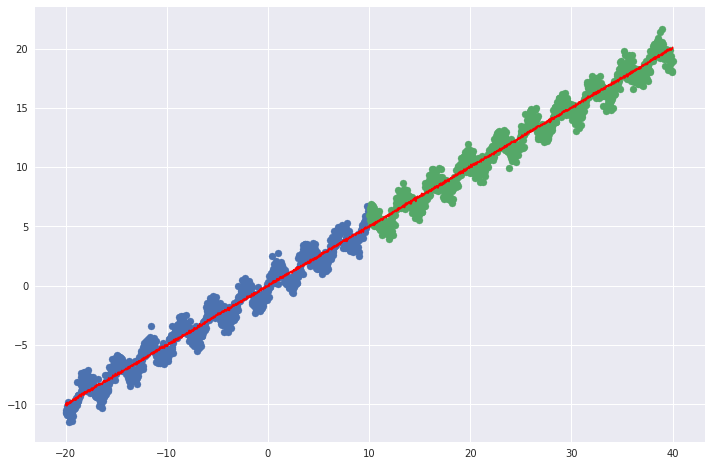

In [181]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 0], Y_train)
plt.plot(X_train[:, 0], res.predict(X_train), c='r')


plt.scatter(X_test[:, 0], Y_test)
plt.plot(X_test[:, 0], res.predict(X_test), c='r')
plt.show()

In [182]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2).fit(X)
X_train_poly = poly.transform(X_train)

In [183]:
res = sm.OLS(Y_train, X_train_poly).fit()

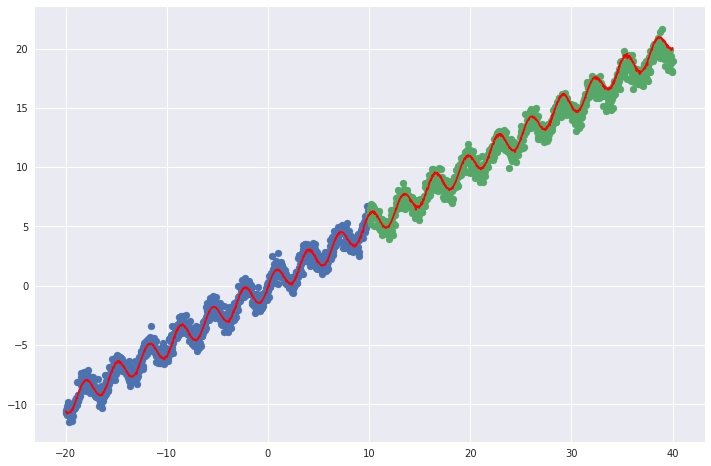

In [185]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 0], Y_train)
plt.plot(X_train[:, 0], res.predict(X_train_poly), c='r')


plt.scatter(X_test[:, 0], Y_test)
plt.plot(X_test[:, 0], res.predict(poly.transform(X_test)), c='r')
# plt.xlim(-5, 0)
# plt.ylim(0, 20)
plt.show()

# RVM

### Relevance Vector Machine

Метод релевантных векторов -- линейная регрессия под амфетамином с дисперсиями и байесовскими методами.

Задача ставится классическим образом: построить модель зависимости для выборки вида $(X, y) = \{ x_i, y_i \}_{i=1}^N$. Причём мы

$$f(x_i) = w^T x_i$$

#### Вероятностная интерпретация линейной регрессии

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) = \prod\limits_{i=1}^{N} \mathcal{N}(y_i | w^T x_i, \sigma^2) \$$

$$= \frac{1}{\sigma^n (2 \pi)^{n/2}} \exp \left( - \frac{\sum\limits_{i=1}^{N} (y_i - w^T x_i)^2}{2 \sigma^2} \right)$$

Переходим к лагорифму:

$$\log p(y|X, w) = -\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 \rightarrow \max_{w}$$



#### Добавление регуляризации с точки зрения байесовских методов

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) p(w), ~~~ p(w) = \mathcal{N}(w | 0, \alpha^{-1})$$


$$-\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 - \frac{\alpha}{2} ||w||_2^2 \rightarrow \max_{w}$$

Другими словами, l2-регуляризация эквивалентна тому что мы вешаем на веса априорную плотность.



Минусы: \sigma^2$ и $\alpha$ одни для всех признаков и фиксированы(нужна кросс-валидация);

### RVR
или почему бы нам не добавить распределение на параметры распределения параметров распределения?

$$p(w|\alpha) = \mathcal{N}(0, A^{-1}),~~~A=\mathrm{diag}(\alpha_1, \dots, \alpha_m)$$

Тогда используя сложную математику(см. [1]) можно придумать как обучать такую модель где для каждого признака будет своя собственная дисперсия, которая подбирается автоматически.

[1] http://www.machinelearning.ru/wiki/images/4/43/BayesML-2007-textbook-2.pdf

[2] http://www.machinelearning.ru/wiki/index.php?title=RVM

In [186]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [187]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

In [188]:
from skbayes.rvm_ard_models import RVR
from sklearn.linear_model import LinearRegression

In [189]:
rvm = RVR(kernel='linear')
rvm.fit(X_train, Y_train)

lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [190]:
Y_pred_rvm, Y_pred_std = rvm.predict_dist(X_test)
Y_pred_lr = lr.predict(X_test)

mean_squared_error(Y_pred_rvm, Y_test), mean_squared_error(Y_pred_lr, Y_test)

(0.7262414771786432, 0.7300179202875026)

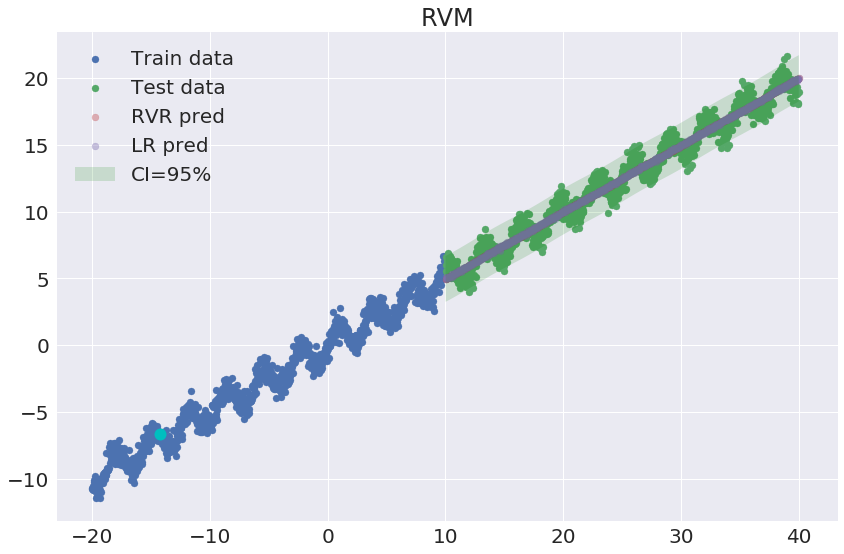

In [191]:
plt.figure(figsize = (14, 9))

plt.scatter(X_train[:, 0], Y_train, label = "Train data")
plt.scatter(X_test[:, 0], Y_test, label = "Test data")
plt.scatter(X_test[:, 0], Y_pred_rvm, label = "RVR pred", alpha=0.4)
plt.scatter(X_test[:, 0], Y_pred_lr, label = "LR pred", alpha=0.4)

plt.fill_between(X_test[:, 0], 
                 Y_pred_rvm - 2 * np.sqrt(Y_pred_std), 
                 Y_pred_rvm + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.plot(rvm.relevant_vectors_[:, 0], Y_train[rvm.active_], "co", markersize = 12)
plt.legend()
plt.title("RVM")
plt.show()

## Bias-Variance


$$\text{Var}(\hat{y}) = E[\hat{y} - y]^2 - (E[\hat{y} - y])^2 $$

$$E[\hat{y} - y]^2 = \text{Var}(\hat{y}) + \text{Bias}(\hat{y})^2$$


Среднее:

$$\bar{y} = \frac{1}{N} \sum \hat{y}_i$$

Тогда смещение определяется так:

$$\text{Bias}(\hat{y})^2=MSE(y, \bar{y})$$

А дисперсия так:

$$\text{Var}(\hat{y})=\frac{1}{N} \sum MSE(\hat{y}_i, \bar{y})$$

In [54]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from tqdm import tqdm

In [55]:
bias_rvr = []
variance_rvr = []
error_rvr = []

bias_lr = []
variance_lr = []
error_lr = []

aics = []
bics = []

degrees = np.arange(1, 10)
resamples = 20

for degree in tqdm(degrees):
    
    Y_preds_rvr = []
    Y_preds_lr = []
    aics_tmp = []
    bics_tmp = []
    for _ in range(resamples):
        X_train_resample, Y_train_resample = resample(X_train, Y_train)
        rvm = RVR(kernel='poly', degree=degree).fit(X_train_resample, Y_train_resample)
        Y_pred_rvr = rvm.predict(X_test)
        Y_preds_rvr.append(Y_pred_rvr)
        
        poly = PolynomialFeatures(degree=degree).fit(X)
        X_train_poly_resample = poly.transform(X_train_resample)
        
        lr = sm.OLS(Y_train_resample, X_train_poly_resample).fit()
        aics_tmp.append(lr.aic)
        bics_tmp.append(lr.bic)
        
        Y_pred_lr = lr.predict(poly.transform(X_test))
        Y_preds_lr.append(Y_pred_lr)
    
    aics.append(np.mean(aics_tmp))
    bics.append(np.mean(bics_tmp))
    
    
    Y_preds_rvr = np.array(Y_preds_rvr)
    bias_rvr.append(
        ((Y_preds_rvr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_rvr.append(
        ((Y_preds_rvr - Y_preds_rvr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_rvr.append(
        ((Y_preds_rvr - Y_test)**2).mean(axis=1).mean()
    )
    
    Y_preds_lr = np.array(Y_preds_lr)
    bias_lr.append(
        ((Y_preds_lr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_lr.append(
        ((Y_preds_lr - Y_preds_lr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_lr.append(
        ((Y_preds_lr - Y_test)**2).mean(axis=1).mean()
    )
    
bias_rvr = np.array(bias_rvr)
variance_rvr = np.array(variance_rvr)
error_rvr = np.array(error_rvr)

bias_lr = np.array(bias_lr)
variance_lr = np.array(variance_lr)
error_lr = np.array(error_lr)

 44%|████▍     | 4/9 [00:16<00:20,  4.08s/it]/home/acapello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function pinvh is deprecated; sklearn.utils.extmath.pinvh was deprecated in version 0.19 and will be removed in 0.21. Use scipy.linalg.pinvh instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/acapello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function pinvh is deprecated; sklearn.utils.extmath.pinvh was deprecated in version 0.19 and will be removed in 0.21. Use scipy.linalg.pinvh instead.
  warnings.warn(msg, category=DeprecationWarning)
100%|██████████| 9/9 [01:25<00:00,  9.47s/it]


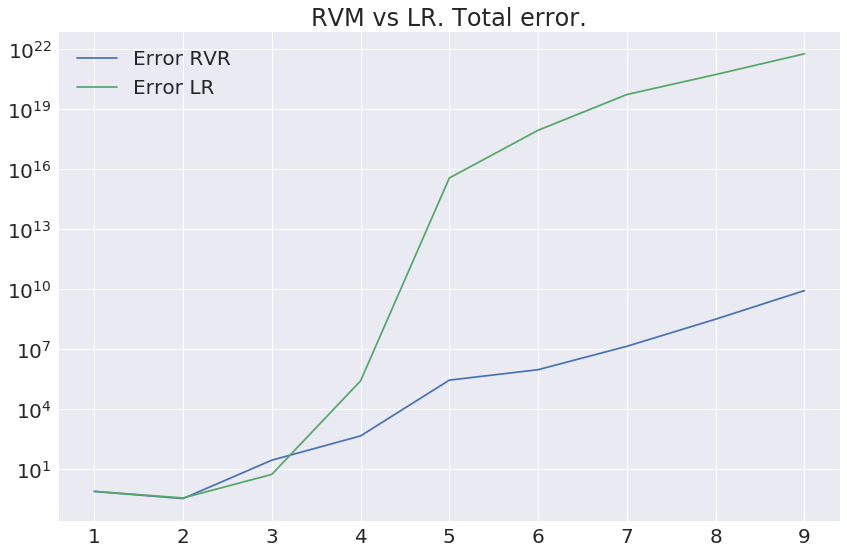

In [56]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, error_rvr, label='Error RVR')
plt.plot(degrees, error_lr, label='Error LR')
plt.yscale('log')
plt.legend()
plt.title("RVM vs LR. Total error.")
plt.show()

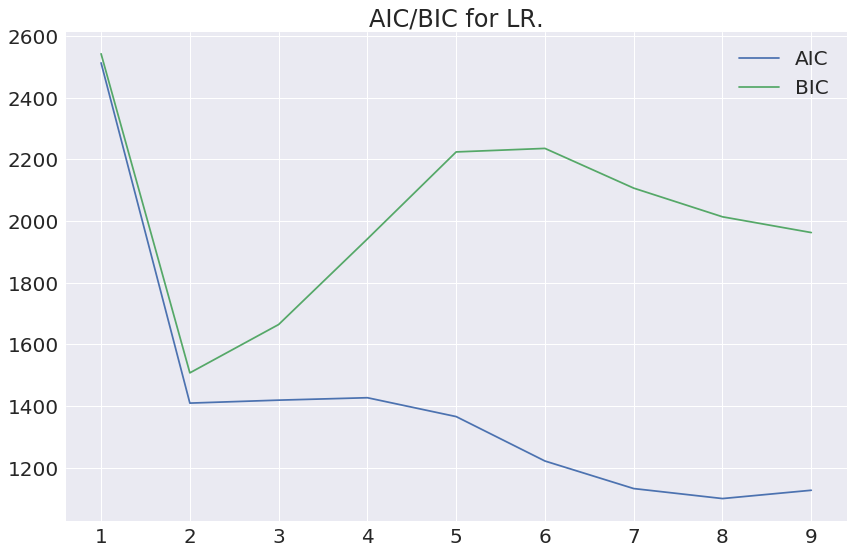

In [57]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, aics, label='AIC')
plt.plot(degrees, bics, label='BIC')
plt.legend()
plt.title("AIC/BIC for LR.")
plt.show()

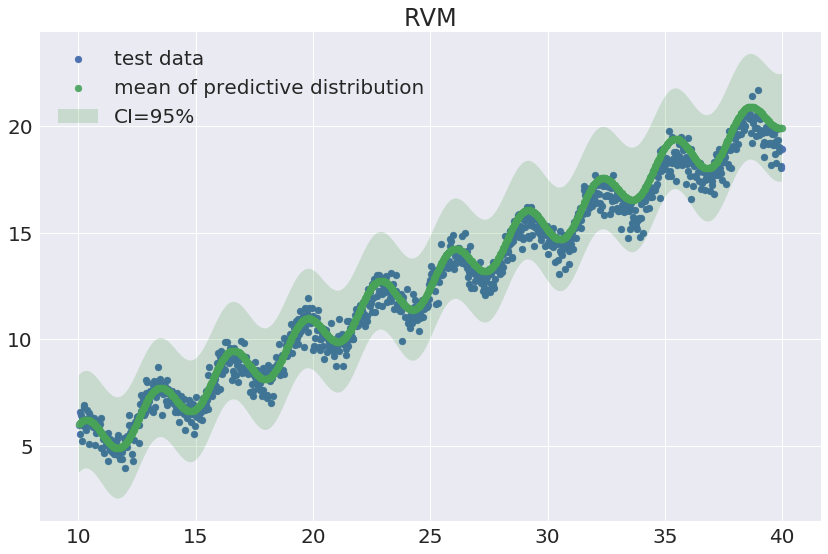

In [192]:
rvm = RVR(kernel='poly', degree=2).fit(X_train, Y_train)
Y_pred, Y_pred_std = rvm.predict_dist(X_test)

plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "test data")
plt.scatter(X_test[:, 0], Y_pred, label = "mean of predictive distribution")
plt.fill_between(X_test[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM")
plt.show()

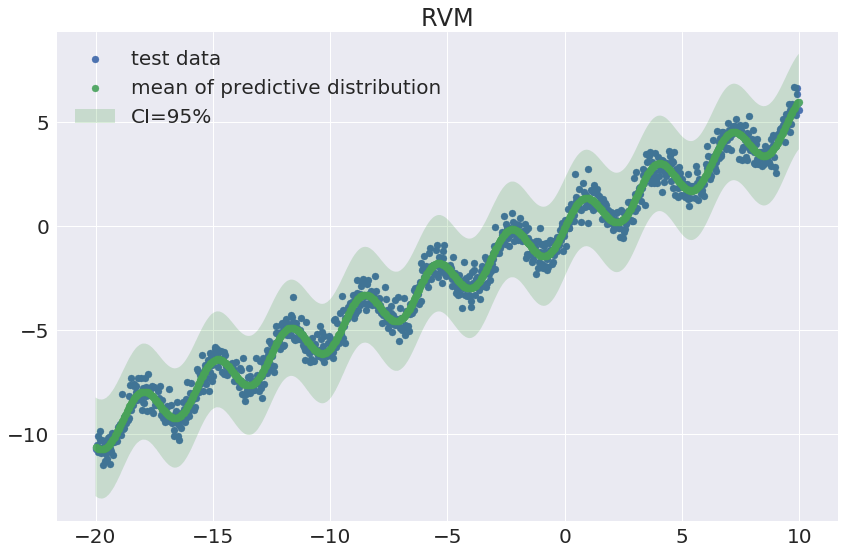

In [193]:
rvm = RVR(kernel='poly', degree=2).fit(X_train, Y_train)
Y_pred, Y_pred_std = rvm.predict_dist(X_train)

plt.figure(figsize = (14, 9))
plt.scatter(X_train[:, 0], Y_train, label = "test data")
plt.scatter(X_train[:, 0], Y_pred, label = "mean of predictive distribution")
plt.fill_between(X_train[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM")
plt.show()

# Gaussian Processes

## План

  * Напишем свой простейший GP;
  * Посмотрим на библиотеку `GPy`;
  * С помощью `GPytorch` научимся использовать Scalable GP;
  * Научимся объединять Deep Learning с GP.
  

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
EPS = 1e-10
sns.set()
warnings.filterwarnings("ignore")

def plot_gp(X_train, y_train, X_test, samples, mu, std):
    plt.figure(figsize=(12, 12))


    plt.plot(X_test, samples.T)

    plt.fill_between(X_test.ravel(), 
                     mu.ravel() - 2 * std.ravel(), 
                     mu.ravel() + 2 * std.ravel(), alpha=0.3)

    plt.plot(X_test, mu, 'r--', lw=2, label='Mean of GP')
    
    plt.scatter(X_train, y_train, s=30, label='Original data')

    plt.title('GP')

    plt.legend()

    plt.show()

## Распределения: совместные, условные, частные

Совместное распределение:

$$(x, y) \sim \mathcal{N}\left(\mu, \Sigma\right), ~\mu = [\mu_1, \mu_2], ~~\Sigma=\begin{bmatrix}\Sigma_{11} & \Sigma_{12} \\ \Sigma_{11}^T & \Sigma_{22} \end{bmatrix}$$

Частное:

$$x \sim  \mathcal{N}(\mu_1, \Sigma_{11})$$


Условное:

$$ (x | y) \sim \mathcal{N}(\mu_1 + \Sigma_{12} \Sigma_{22}^{-1}(y - \mu_2), \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{12}^T)$$

In [195]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[2., 1.5], 
                     [1.5, 2.]])
}

##### Совместное и частные распределения:

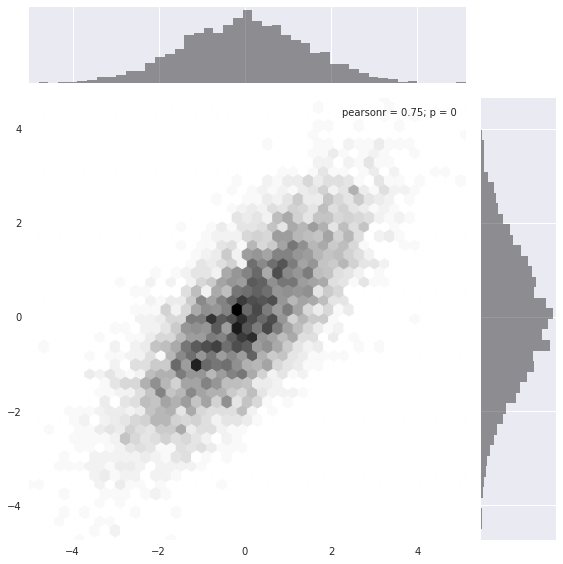

In [196]:
X_sample = np.random.multivariate_normal(size=5000, **parameters)
sns.jointplot(x=X_sample[:, 0], y=X_sample[:, 1], kind="hex", color="k", size=8);

##### Условные распределения:

In [197]:
y = np.linspace(-5, 5, 1000)

In [198]:
mu = parameters['mean'][0] + parameters['cov'][0, 1] * (y - parameters['mean'][1]) / parameters['cov'][1, 1]

var = parameters['cov'][0, 0] - parameters['cov'][0, 1]**2 / parameters['cov'][1, 1]

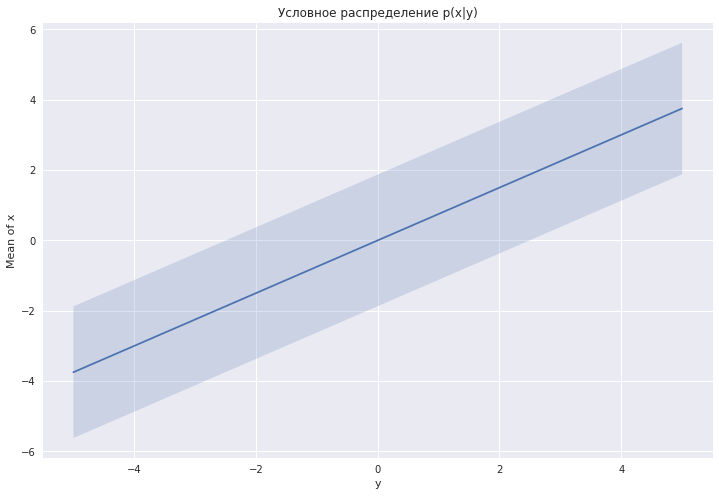

In [199]:
plt.figure(figsize=(12, 8))
plt.plot(y, mu)
plt.fill_between(y, mu - 2 * np.sqrt(var), mu + 2 * np.sqrt(var), alpha=0.2)
plt.title('Условное распределение p(x|y)')
plt.ylabel('Mean of x')
plt.xlabel('y')
plt.show()

### Ядра и, в частности, ~~пушечные~~ гауссовы

$$\mathrm{kern}: X \times X \rightarrow \mathbb{R} $$

Ядро это функция, которая отображает декартово произведение некоторого пространства с самим собой на действительную ось.

Больше инфы про ядра: http://www.machinelearning.ru/wiki/index.php?title=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D1%8F%D0%B4%D1%80%D0%B0

#### Гауссово ядро

$$\mathrm{kern}(x, y) \sim \exp\left( -\frac{||x - y||_2}{2 \sigma^2} \right)$$

In [200]:
class GaussianKernel:
    def __init__(self, sigma):
        self.sigma = sigma
    def __call__(self, x_train, x_test):
        # l2-норма между матрицами x_train[N, K] y_train[M, K]
        # Выходом должна быть матрица [N, M]
        dist = (np.sum(x_train**2, 1)[:, None] + 
                np.sum(x_test**2, 1)[None, :] - 
                2 * x_train.dot(x_test.T)) 
        k = np.exp(- dist / self.sigma**2 / 2)
        return k

### Причём здесь гауссовы процессы?

Пусть у нас есть выборка $X_{train}, y_{train}$ и есть $X_{test}$ для которых мы хотим построить вероятностную модель для $y_{test}$. А ещё мы выбрали некоторое ядро $\mathrm{kern}(\cdot, \cdot)$.

Тогда гауссова регрессия(гауссов процесс) записывается следующим образом:

$$p(X_{test}, y_{test}, X_{train}, y_{train}) = \mathcal{N}\left( 0 , \begin{bmatrix}K + \sigma^2 I & K_* \\ K_*^T & K_{**} \end{bmatrix} \right), $$

где

$$K = \mathrm{kern}(X_{train}, X_{train})$$

$$K_{*} = \mathrm{kern}(X_{train}, X_{test})$$

$$K_{**} = \mathrm{kern}(X_{test}, X_{test})$$

Т.е. матрица ковариаций это матрица ядра. Как мы увидим дальше, выбор ядра __очень важен__ и зависит от задачи.

Тогда наша задача это найти следующее распределение:

$$p(y_{test} | X_{test}, X_{train}, y_{train}) \sim \mathcal{N}\left(K_{*}^T (K + \sigma^2 I)^{-1} y_{train}, K_{**} - K_{*} (K + \sigma^2 I)^{-1} K_{*}^T\right)$$

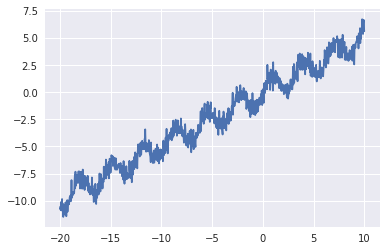

In [201]:
plt.plot(X_train[:, 0], Y_train.ravel())

### Какое сейчас время? Время Гауссовой Регрессии!

In [202]:
class GaussianRegression:
    def __init__(self, kernel, X, y, noise=EPS):
        self.kernel = kernel
        self.X_train = X
        self.y_train = y
        self.noise = noise
        
        self.K_train = self.kernel(self.X_train, self.X_train)
        self.L_train = np.linalg.cholesky(self.K_train + self.noise * np.eye(len(X_train)))
        self.K_inv = np.linalg.pinv(self.K_train + self.noise * np.eye(len(X_train)))
    
    def predict(self, X_test):
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        # std
        std = np.sqrt(np.diag(cov))
        
        return mu.reshape((len(X_test), -1)), std.reshape((len(X_test), -1))
    
    def sample(self, X_test, n=1):
        # copy-paste code above
        
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        samples = np.random.multivariate_normal(size=n, mean=mu.ravel(), cov=cov)
        
        return samples.T

In [203]:
kernel = GaussianKernel(1.)

In [204]:
gregressor = GaussianRegression(kernel=kernel, X=X_train, y=Y_train, noise=1e-3)

In [205]:
mu, std = gregressor.predict(X)
samples = gregressor.sample(X, n=3).T

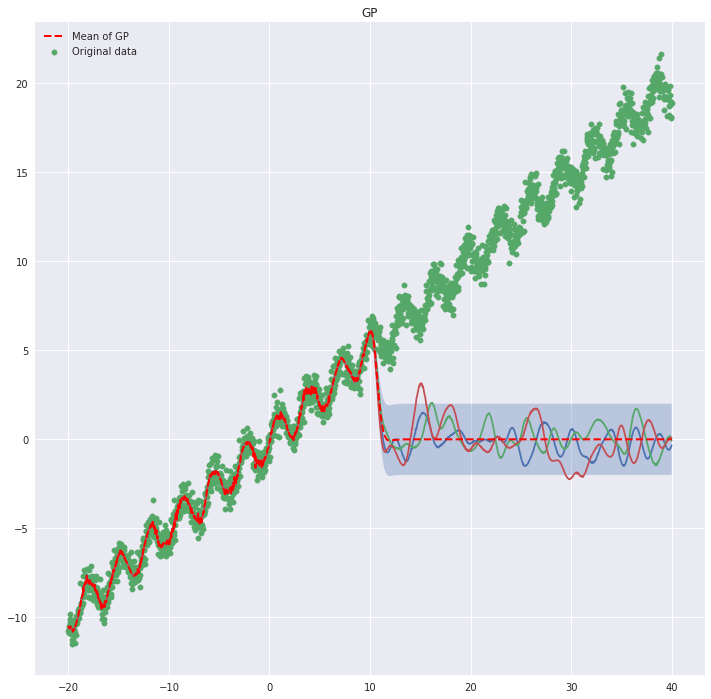

In [206]:
plot_gp(X_train=X[:, 0], y_train=Y, 
        X_test=X[:, 0], samples=samples, mu=mu, std=std)

## GPy

Чтобы не прогать самим и не делать кучу ошибок, лучше использовать готовые решения :)


In [207]:
import GPy

In [208]:
kern = GPy.kern.RBF(input_dim=5, lengthscale=1., variance=1.)

In [209]:
kern.plot()

TypeError: calculated free_dims [0 1 2 3 4] from visible_dims None and fixed_dims [] is neither 1D nor 2D

In [ ]:
# нормальные ребята используют для регрессии GPRegression
# clf=GPy.models.GPRegression(X_train, y_train, kern)

In [210]:
# но нам и так нормально
clf=GPy.core.GP(X=X_train, 
                Y=Y_train.reshape(-1, 1), 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=1e-2))

In [211]:
clf.optimize(messages=True, optimizer='scg')

HBox(children=(VBox(children=(IntProgress(value=0, max=1000), HTML(value=''))), Box(children=(HTML(value=''),))))

TypeError: unsupported format string passed to NoneType.__format__

In [96]:
mu, cov = clf.predict(X, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=3, mean=mu.ravel(), cov=cov)

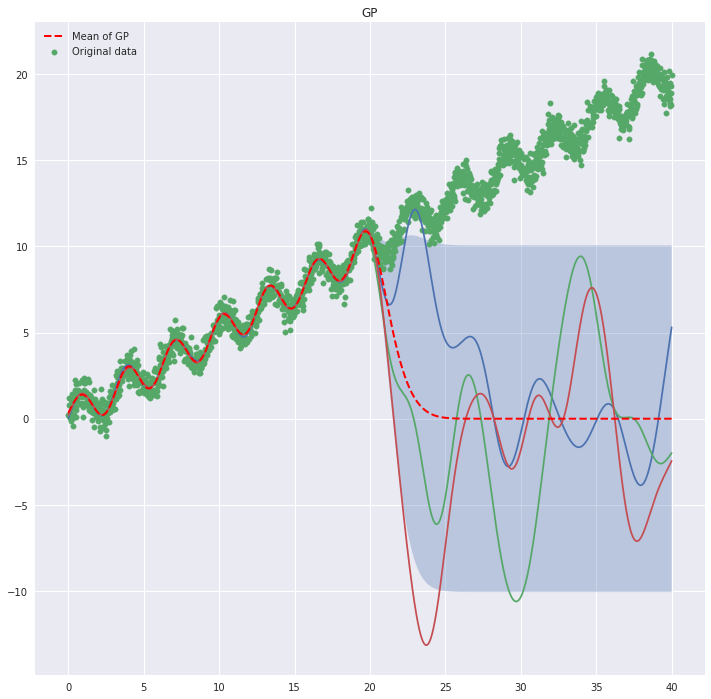

In [97]:
plot_gp(X_train=X[:, 0], y_train=Y, 
        X_test=X[:, 0], samples=samples, mu=mu, std=std)

### MOAR KERNELS

In [265]:
kern = GPy.kern.Cosine(input_dim=1, variance=1, lengthscale=1) + GPy.kern.Linear(input_dim=1)

In [266]:
clf=GPy.core.GP(X=X_train, 
                Y=Y_train.reshape(-1, 1), 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=2.))

In [267]:
clf.optimize(messages=True, optimizer='lbfgsb')

HBox(children=(VBox(children=(IntProgress(value=0, max=1000), HTML(value=''))), Box(children=(HTML(value=''),))))

In [268]:
mu, cov = clf.predict(X, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=10, mean=mu.ravel(), cov=cov)

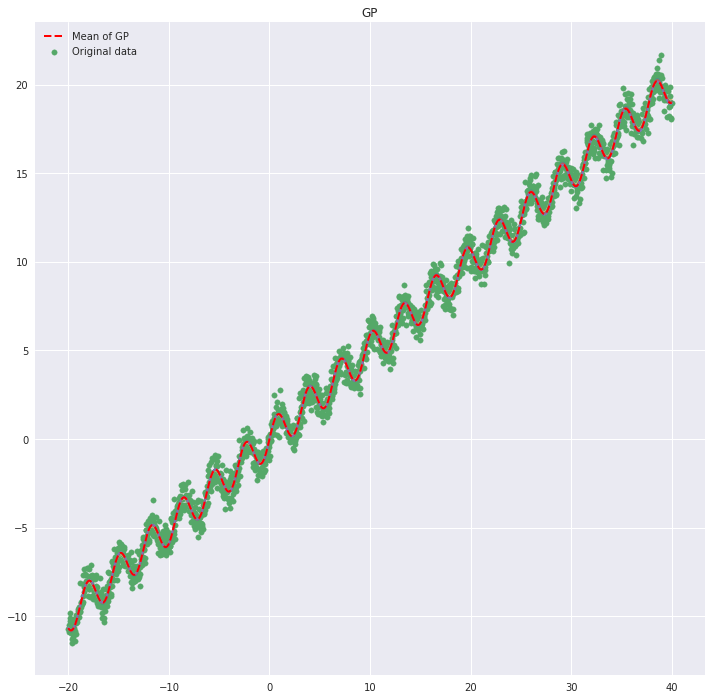

In [269]:
plot_gp(X_train=X[:, 0], y_train=Y, 
        X_test=X[:, 0], samples=samples, mu=mu, std=std)

# Deep Kernel Learning with GP